# Loading Data

In [45]:
import pandas as pd

data1 = pd.read_csv( 'data/train.csv')

data2 = pd.read_csv( 'data/comments.csv')

data = pd.concat( ( data1, data2)).reset_index(drop=True)

data = data.drop_duplicates(subset='comment', keep='first')

X = data[ 'comment']
y = data[ 'label']

In [46]:
print( "Number of Comments in data:", X.shape[0])

Number of Comments in data: 2682


# Data Visualization

<Axes: xlabel='label', ylabel='count'>

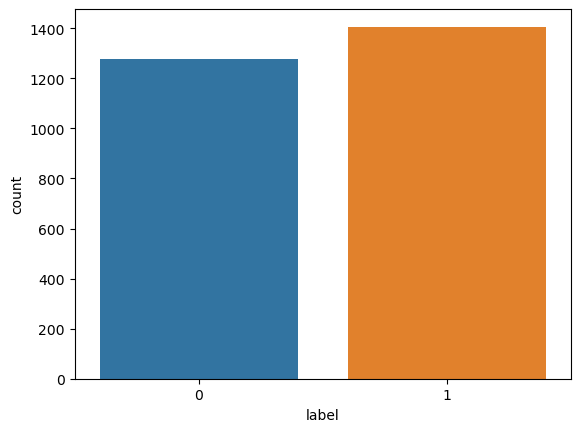

In [47]:
import seaborn as sns

sns.countplot( x=y)

# Spliting Data to Train/Test

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify = y)

In [49]:
print( "Train size:", X_train.shape[0], '\nTest size:', X_test.shape[0])

Train size: 2145 
Test size: 537


<Axes: xlabel='label', ylabel='count'>

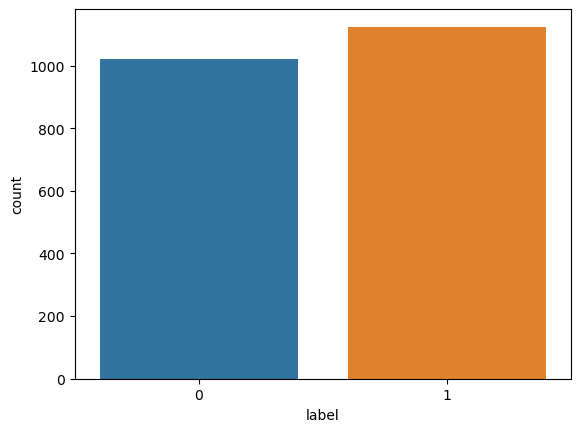

In [50]:
sns.countplot( x=y_train)

<Axes: xlabel='label', ylabel='count'>

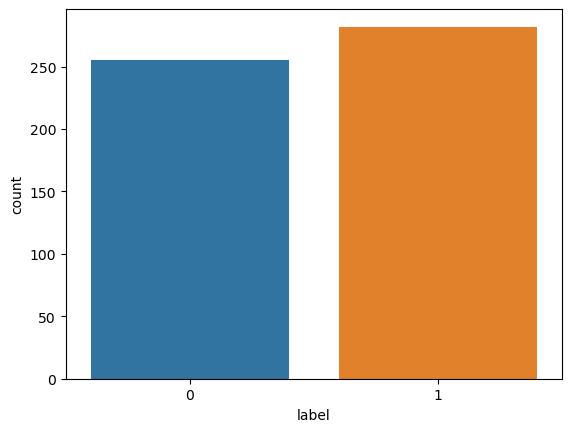

In [51]:
sns.countplot( x=y_test)

# Loading Word2Vec Model

In [52]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("models/word2vec-arabic.model")

# Intializing HyperParameters

In [53]:
import numpy as np

sentence_lengths = 610

#max_length = int( np.percentile(sentence_lengths, 95))
max_length = 128

embedding_dim = w2v_model.vector_size

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts( data)

total_words = len( tokenizer.word_index)

# Converting Test to Seuence and then Pad

In [54]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts( data)

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences( X_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

# Convert text to sequences and pad them
test_sequences = tokenizer.texts_to_sequences( X_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Defining CallBacks

In [55]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

EarlyStopping = EarlyStopping(monitor='val_loss', 
                                patience=6, 
                                restore_best_weights=True)

model_save = ModelCheckpoint('best_model.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.0001)

# Initilizing Embedding Metrix

In [56]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Building Model

In [57]:
from tensorflow.keras.layers import  Embedding, Flatten, Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam


model = Sequential()

model.add( Embedding(total_words+1, embedding_dim, weights=[ embedding_matrix], input_length=max_length, trainable=False),)
model.add( Bidirectional( LSTM(16)))
model.add( Flatten(),)
model.add( BatchNormalization(),)
model.add( Dropout(0.50),)
model.add( Dense( embedding_dim, activation='relu'),)
model.add( BatchNormalization())
model.add( Dropout(0.30))
model.add( Dense(8,activation='relu'))
model.add( Dense(1,activation='sigmoid'))




model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [58]:
print("Shape of embedding_matrix:", embedding_matrix.shape)

print("Total number of words:", total_words)


Shape of embedding_matrix: (4, 100)
Total number of words: 3


# Visualizing Summary of Model

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 128, 100)          400       
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                14976     
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 100)              

# Training the Model

In [64]:
history = model.fit( train_padded_sequences, y_train,
                       validation_split=0.2,
                       epochs = 100,
                       batch_size= 16,
                       callbacks=[ EarlyStopping, model_save, rlr])

32/33 [============================>.] - ETA: 0s - loss: 1.6416 - accuracy: 0.3701
Epoch 1: val_loss improved from inf to 1.35633, saving model to modelest_model_1_12.keras
33/33 [==============================] - 12s 114ms/step - loss: 1.6278 - accuracy: 0.3750 - val_loss: 1.3563 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.6212
Epoch 2: val_loss improved from 1.35633 to 1.05026, saving model to modelest_model_1_12.keras
33/33 [==============================] - 1s 34ms/step - loss: 0.9847 - accuracy: 0.6212 - val_loss: 1.0503 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.7491 - accuracy: 0.7354
Epoch 3: val_loss improved from 1.05026 to 0.96742, saving model to modelest_model_1_12.keras
33/33 [==============================] - 1s 32ms/step - loss: 0.7402 - accuracy: 0.7405 - val_loss: 0.9674 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 4/100
33/33 

# Visualizinf Training Progress

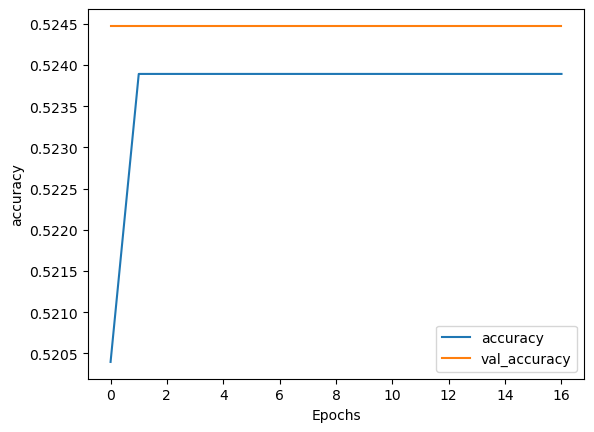

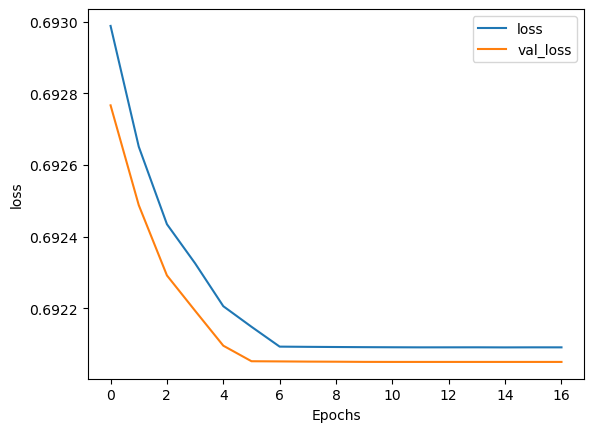

In [61]:
import matplotlib.pyplot as plt

def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Model performence on Test Data

17/17 [==============================] - 2s 16ms/step


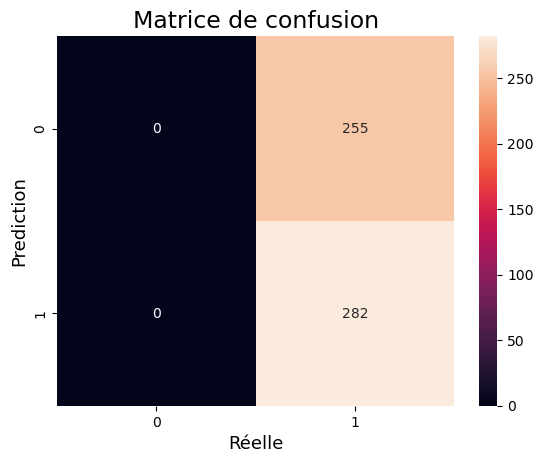

In [62]:
predicted_test = model.predict( test_padded_sequences)
binary_predictions = ( predicted_test > 0.5).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix( y_test, binary_predictions)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Réelle',fontsize=13)
plt.title('Matrice de confusion',fontsize=17)
plt.show()

In [63]:
from tensorflow.keras.models import load_model

the_model = load_model('best_model.keras')

model.evaluate(  test_padded_sequences, y_test)

17/17 [==============================] - 0s 15ms/step - loss: 0.6920 - accuracy: 0.5251


[0.6920035481452942, 0.5251396894454956]